In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#remove training logs
import shutil

# Specify the path to the directory
directory_path = '/kaggle/working/Logs'

# Remove the directory and its contents
shutil.rmtree(directory_path)


# Parameters

In [2]:
epochs=150
batch_size=1024
window_length = 640  # For example, use a window length of 10
num_features=3
number_of_features=3
model_name="LSTM-HART-3features-2classes"
num_classes=2
patience=15
class_names3 = {
    0: 'Normal',
    1: 'Medium',
    2: 'High'
}
class_names2 = {
    0: 'Normal',
    1: 'High'
}

In [ ]:
import pandas as pd 
df = pd.read_csv("/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv")
df

In [ ]:
# Assuming your DataFrame is df and the column is 'ID'
# Convert integer values to strings
df['id'] = df['id'].astype(str)
# Assuming df is your DataFrame
df['label'] = df['label'].replace(1, 0) # for binary classification

# Print the DataFrame to verify the conversion
print(df)


In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Count the number of samples for each ID and label
id_label_counts = df.groupby(['id', 'label']).size().unstack(fill_value=0)

# Plot the grouped bar graph
plt.figure(figsize=(12, 6))
id_label_counts.plot(kind='bar', stacked=True)
plt.xlabel('ID')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples for Each ID Across All Labels')
# 3 classes
count = len(set(df['label']))
print(count)
if count==3:
    plt.legend(title='Label', labels=['Normal','Medium','High'])
# 2 classes
else:
    plt.legend(title='Label', labels=['Normal','High'])
plt.show()

testing_ids = ['7E', '8B','E4']
val_ids=['94','CE']

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def visualize_class_distribution(df, label_column):
    # Map class labels to categories
    label_mapping = {0: 'Normal', 1: 'Medium', 2: 'High'}
    df['category'] = df[label_column].map(label_mapping)

    # Calculate class counts
    class_counts = df['category'].value_counts()

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Dataset Class Distribution')
    plt.legend(title='Stress Level', loc='upper right', labels=class_counts.index)
    plt.show()

In [ ]:
visualize_class_distribution(df, 'label')

In [ ]:
df= df.drop(columns=['category'],axis=1)

In [1]:
df1=df[['X','Y','Z','datetime','id','label']]
df2=df[['EDA','HR','TEMP','datetime','id','label']]

NameError: name 'df' is not defined

In [ ]:
#testing data
all_ids = set(df['id'])
exclude_ids = set(testing_ids + val_ids)
train_ids = list(all_ids - exclude_ids)

# Filter the DataFrame based on the specified ID values
Testing_data1 = df[df['id'].isin(testing_ids)]
val_data1 = df[df['id'].isin(val_ids)]
train_data1 = df[df['id'].isin(train_ids)]

Testing_data2 = df2[df2['id'].isin(testing_ids)]
val_data2 = df2[df2['id'].isin(val_ids)]
train_data2 = df2[df2['id'].isin(train_ids)]

del all_ids,val_ids,testing_ids,train_ids

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_labels= to_categorical(encoded_labels)
    return encoded_labels

In [ ]:
import numpy as np

def apply_sliding_windowing_new(df, window_length, num_features, overlap=0.3, ftrs=['X', 'Y', 'Z']):
    # Sort the values by 'id' and 'datetime' columns
    df_sorted = df.sort_values(by=['id', 'datetime'])
#     print(df_sorted)
    # Initialize arrays to store reshaped data and labels
    reshaped_data = []
    labels = []

    # Set the initial start index
    start_idx = 0

    while start_idx + window_length <= len(df_sorted):
        # Set the end index for the current window
        end_idx = start_idx + window_length

        # Create a subset of the DataFrame for the current window
        subset_df = df_sorted.iloc[start_idx:end_idx]

        # Extract features from the subset DataFrame and convert to numpy array
        subset_features = subset_df[ftrs].values
        reshaped_data.append(subset_features)

        # Extract label for the current window and encode it
        label = subset_df['label'].iloc[0]  # Assuming the label is the same for all rows in the window
        labels.append(label)

        # Update the start index for the next window
        start_idx = end_idx - int(window_length * (1 - overlap))

    # Convert the list of arrays to a single numpy array
    reshaped_data = np.array(reshaped_data)

    # Encode labels
    labels_encoded = encode_labels(np.array(labels))

    return reshaped_data, labels_encoded

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def apply_minmax_scaling(df,features=['X', 'Y', 'Z']):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Apply MinMaxScaler to 'x', 'y', 'z' columns
    df[features] = scaler.fit_transform(df[features])

    return df

# Example usage
# Assuming df is your DataFrame
# df_normalized = apply_minmax_scaling(df)


In [ ]:
features1 = ['X', 'Y', 'Z']
train_data1 = apply_minmax_scaling(train_data1,features=features1)
Testing_data1 = apply_minmax_scaling(Testing_data1,features=features1)
val_data1 = apply_minmax_scaling(val_data1,features=features1)

features2 = ['EDA','HR','TEMP']
train_data2 = apply_minmax_scaling(train_data2,features=features2)
Testing_data2 = apply_minmax_scaling(Testing_data2,features=features2)
val_data2 = apply_minmax_scaling(val_data2,features=features2)

In [ ]:
print("Processing x_Val1...")
x_val1, y_val1 = apply_sliding_windowing_new(val_data1, window_length, num_features,overlap=0.5,ftrs=features1)

print("Processing x_test1...")
x_test1, y_test1 = apply_sliding_windowing_new(Testing_data1, window_length, num_features,overlap=0.5,ftrs=features1)

print("Processing x_train1...")
x_train1, y_train1 = apply_sliding_windowing_new(train_data1, window_length, num_features,overlap=0.5,ftrs=features1)


In [ ]:
print("Processing x_Val2...")
x_val2, y_val2 = apply_sliding_windowing_new(val_data2, window_length, num_features,overlap=0.5,ftrs=features2)

print("Processing x_test2...")
x_test2, y_test2 = apply_sliding_windowing_new(Testing_data2, window_length, num_features,overlap=0.5,ftrs=features2)

print("Processing x_train2...")
x_train2, y_train2 = apply_sliding_windowing_new(train_data2, window_length, num_features,overlap=0.5,ftrs=features2)


In [ ]:
print(x_train1.shape)  # Check the shape of the reshaped data
print(x_test1.shape)  # Check the shape of the reshaped data
print(x_val1.shape)  # Check the shape of the reshaped data
print(y_train1.shape)  # Check the shape of the reshaped data
print(y_test1.shape)  # Check the shape of the reshaped data
print(y_val1.shape)  # Check the shape of the reshaped data

In [ ]:
print(x_train2.shape)  # Check the shape of the reshaped data
print(x_test2.shape)  # Check the shape of the reshaped data
print(x_val2.shape)  # Check the shape of the reshaped data
print(y_train2.shape)  # Check the shape of the reshaped data
print(y_test2.shape)  # Check the shape of the reshaped data
print(y_val2.shape)  # Check the shape of the reshaped data

In [ ]:
import os
import numpy as np

def save_numpy_to_directory(numpy_array, directory, file_name):
    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Save the NumPy array to the specified directory
    file_path = os.path.join(directory, file_name)
    np.save(file_path, numpy_array)

In [ ]:
directory_path="/kaggle/working"
file_name = "x_train1.npy"
save_numpy_to_directory(x_train1, directory_path, file_name)

file_name = "y_train1.npy"
save_numpy_to_directory(y_train1, directory_path, file_name)

file_name = "x_test1.npy"
save_numpy_to_directory(x_test1, directory_path, file_name)

file_name = "y_test1.npy"
save_numpy_to_directory(y_test1, directory_path, file_name)

file_name = "x_val1.npy"
save_numpy_to_directory(x_val1, directory_path, file_name)

file_name = "y_val1.npy"
save_numpy_to_directory(y_val1, directory_path, file_name)


In [ ]:
directory_path="/kaggle/working"
file_name = "x_train2.npy"
save_numpy_to_directory(x_train2, directory_path, file_name)

file_name = "y_train2.npy"
save_numpy_to_directory(y_train2, directory_path, file_name)

file_name = "x_test2.npy"
save_numpy_to_directory(x_test2, directory_path, file_name)

file_name = "y_test2.npy"
save_numpy_to_directory(y_test2, directory_path, file_name)

file_name = "x_val2.npy"
save_numpy_to_directory(x_val2, directory_path, file_name)

file_name = "y_val2.npy"
save_numpy_to_directory(y_val2, directory_path, file_name)


In [3]:
import numpy as np

def load_numpy_from_file(file_path):
    # Load the NumPy array from the specified file path
    numpy_array = np.load(file_path)
    return numpy_array



In [4]:
# Example usage
file_path = "/kaggle/working/x_train1.npy"
x_train1 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_train1.npy"
y_train1 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/x_test1.npy"
x_test1 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_test1.npy"
y_test1 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/x_val1.npy"
x_val1 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_val1.npy"
y_val1 = load_numpy_from_file(file_path)


In [5]:
# Example usage
file_path = "/kaggle/working/x_train2.npy"
x_train2 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_train2.npy"
y_train2 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/x_test2.npy"
x_test2 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_test2.npy"
y_test2 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/x_val2.npy"
x_val2 = load_numpy_from_file(file_path)
# Example usage
file_path = "/kaggle/working/y_val2.npy"
y_val2 = load_numpy_from_file(file_path)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Concatenate,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model

2024-04-27 20:21:04.430056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 20:21:04.430121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 20:21:04.431663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

from matplotlib import pyplot
import matplotlib.pyplot as plt
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tensorflow.keras.utils import plot_model
import datetime


In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import tensorflow as tf

from tensorflow.keras import layers
import numpy as np

randomSeed = 1
# tf.random.set_seed(randomSeed)

class DropPath(layers.Layer):
    def __init__(self, drop_prob=0.0, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x,training=None):
        if(training):
            input_shape = tf.shape(x)
            batch_size = input_shape[0]
            rank = x.shape.rank
            shape = (batch_size,) + (1,) * (rank - 1)
            random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
            path_mask = tf.floor(random_tensor)
            output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
            return output
        else:
            return x 

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'drop_prob': self.drop_prob,})
        return config

class GatedLinearUnit(layers.Layer):
    def __init__(self,units,**kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.units = units
        self.linear = layers.Dense(units * 2)
        self.sigmoid = tf.keras.activations.sigmoid
    def call(self, inputs):
        linearProjection = self.linear(inputs)
        softMaxProjection = self.sigmoid(linearProjection[:,:,self.units:])
        return tf.multiply(linearProjection[:,:,:self.units],softMaxProjection)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units,})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim,**kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = patch + self.position_embedding(positions)
        return encoded
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection_dim,})
        return config

class ClassToken(layers.Layer):
    def __init__(self, hidden_size,**kwargs):
        super(ClassToken, self).__init__(**kwargs)
        self.cls_init = tf.random.normal
        self.hidden_size = hidden_size
        self.cls = tf.Variable(
            name="cls",
            initial_value=self.cls_init(shape=(1, 1, self.hidden_size), seed=randomSeed, dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_broadcasted = tf.cast(
            tf.broadcast_to(self.cls, [batch_size, 1, self.hidden_size]),
            dtype=inputs.dtype,
        )
        return tf.concat([cls_broadcasted, inputs], 1)
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'hidden_size': self.hidden_size,})
        return config

class Prompts(layers.Layer):
    def __init__(self, projectionDims,promptCount = 1,**kwargs):
        super(Prompts, self).__init__(**kwargs)
        self.cls_init = tf.random.normal
        self.projectionDims = projectionDims
        self.promptCount = promptCount
        self.prompts = [tf.Variable(
            name="prompt"+str(_),
            initial_value=self.cls_init(shape=(1, 1, self.projectionDims), seed=randomSeed, dtype="float32"),
            trainable=True,
        )  for _ in range(promptCount)]

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        prompt_broadcasted = tf.concat([tf.cast(tf.broadcast_to(promptInits, [batch_size, 1, self.projectionDims]),dtype=inputs.dtype,)for promptInits in self.prompts],1)
        return tf.concat([inputs,prompt_broadcasted], 1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'projectionDims': self.projectionDims,
            'promptCount': self.promptCount,})
        return config
    
class SensorWiseMHA(layers.Layer):
    def __init__(self, projectionQuarter, num_heads,startIndex,stopIndex,dropout_rate = 0.0,dropPathRate = 0.0, **kwargs):
        super(SensorWiseMHA, self).__init__(**kwargs)
        self.projectionQuarter = projectionQuarter
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.MHA = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.projectionQuarter, dropout = dropout_rate )
        self.startIndex = startIndex
        self.stopIndex = stopIndex
        self.dropPathRate = dropPathRate
        self.DropPath = DropPath(dropPathRate)
    def call(self, inputData, training=None, return_attention_scores = False):
        extractedInput = inputData[:,:,self.startIndex:self.stopIndex]
        if(return_attention_scores):
            MHA_Outputs, attentionScores = self.MHA(extractedInput,extractedInput,return_attention_scores = True )
            return MHA_Outputs , attentionScores
        else:
            MHA_Outputs = self.MHA(extractedInput,extractedInput)
            MHA_Outputs = self.DropPath(MHA_Outputs)
            return MHA_Outputs
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'projectionQuarter': self.projectionQuarter,
            'num_heads': self.num_heads,
            'startIndex': self.startIndex,
            'dropout_rate': self.dropout_rate,
            'stopIndex': self.stopIndex,
            'dropPathRate': self.dropPathRate,})
        return config
def softDepthConv(inputs):
    kernel = inputs[0]
    inputData = inputs[1]
    convOutputs = tf.nn.conv1d(
    inputData,
    kernel,
    stride = 1,
    padding = 'SAME',
    data_format='NCW',)
    return convOutputs




class liteFormer(layers.Layer):
    def __init__(self,startIndex,stopIndex, projectionSize, kernelSize = 16, attentionHead = 3, use_bias=False, dropPathRate = 0.0,dropout_rate = 0,**kwargs):
        super(liteFormer, self).__init__(**kwargs)
        self.use_bias = use_bias
        self.startIndex = startIndex
        self.stopIndex = stopIndex
        self.kernelSize = kernelSize
        self.softmax = tf.nn.softmax
        self.projectionSize = projectionSize
        self.attentionHead = attentionHead 
        self.DropPathLayer = DropPath(dropPathRate)
        self.projectionHalf = projectionSize // 2
    def build(self,inputShape):
        self.depthwise_kernel = [self.add_weight(
            shape=(self.kernelSize,1,1),
            initializer="glorot_uniform",
            trainable=True,
            name="convWeights"+str(_),
            dtype="float32") for _ in range(self.attentionHead)]
        if self.use_bias:
            self.convBias = self.add_weight(
                shape=(self.attentionHead,), 
                initializer="glorot_uniform", 
                trainable=True,  
                name="biasWeights",
                dtype="float32"
            )
        
    def call(self, inputs,training=None):
        formattedInputs = inputs[:,:,self.startIndex:self.stopIndex]
        inputShape = tf.shape(formattedInputs)
        reshapedInputs = tf.reshape(formattedInputs,(-1,self.attentionHead,inputShape[1]))
        if(training):
            for convIndex in range(self.attentionHead):
                self.depthwise_kernel[convIndex].assign(self.softmax(self.depthwise_kernel[convIndex], axis=0))
        convOutputs = tf.convert_to_tensor([tf.nn.conv1d(
            reshapedInputs[:,convIndex:convIndex+1,:],
            self.depthwise_kernel[convIndex],
            stride = 1,
            padding = 'SAME',
            data_format='NCW',) for convIndex in range(self.attentionHead) ])
        convOutputsDropPath = self.DropPathLayer(convOutputs)
        localAttention = tf.reshape(convOutputsDropPath,(-1,inputShape[1],self.projectionSize))
        return localAttention
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'use_bias': self.use_bias,
            'kernelSize': self.kernelSize,
            'startIndex': self.startIndex,
            'stopIndex': self.stopIndex,
            'projectionSize': self.projectionSize,
            'attentionHead': self.attentionHead,})
        return config          

class mixAccGyro(layers.Layer):
    def __init__(self,projectionQuarter,projectionHalf,projection_dim,**kwargs):
        super(mixAccGyro, self).__init__(**kwargs)
        self.projectionQuarter = projectionQuarter
        self.projectionHalf = projectionHalf
        self.projection_dim = projection_dim
        self.projectionThreeFourth = self.projectionHalf+self.projectionQuarter
        self.mixedAccGyroIndex = tf.reshape(tf.transpose(tf.stack(
            [np.arange(projectionQuarter,projectionHalf), np.arange(projectionHalf,projectionHalf + projectionQuarter)])),[-1])
        self.newArrangement = tf.concat((np.arange(0,projectionQuarter),self.mixedAccGyroIndex,np.arange(self.projectionThreeFourth,projection_dim)),axis = 0)
    def call(self, inputs):
        return tf.gather(inputs,self.newArrangement,axis= 2)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'projectionQuarter': self.projectionQuarter,
            'projectionHalf': self.projectionHalf,
            'projection_dim': self.projection_dim,
        })
        return config

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def mlp2(x, hidden_units, dropout_rate):
    x = layers.Dense(hidden_units[0],activation=tf.nn.swish)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_units[1])(x)
    return x

def depthMLP(x, hidden_units, dropout_rate):
    x = layers.Dense(hidden_units[0])(x)
    x = layers.DepthwiseConv1D(3,data_format='channels_first',activation=tf.nn.swish)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_units[1])(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

class SensorPatchesTimeDistributed(layers.Layer):
    def __init__(self, projection_dim,filterCount,patchCount,frameSize = 128, channelsCount = 6,**kwargs):
        super(SensorPatchesTimeDistributed, self).__init__(**kwargs)
        self.projection_dim = projection_dim
        self.frameSize = frameSize
        self.channelsCount = channelsCount
        self.patchCount = patchCount
        self.filterCount = filterCount
        self.reshapeInputs = layers.Reshape((patchCount, frameSize // patchCount, channelsCount))
        self.kernelSize = (projection_dim//2 + filterCount) // filterCount
        self.accProjection = layers.TimeDistributed(layers.Conv1D(filters = filterCount,kernel_size = self.kernelSize,strides = 1, data_format = "channels_last"))
        self.gyroProjection = layers.TimeDistributed(layers.Conv1D(filters = filterCount,kernel_size = self.kernelSize,strides = 1, data_format = "channels_last"))
        self.flattenTime = layers.TimeDistributed(layers.Flatten())
        assert (projection_dim//2 + filterCount) / filterCount % self.kernelSize == 0
        print("Kernel Size is "+str((projection_dim//2 + filterCount) / filterCount))
#         assert 
    def call(self, inputData):
        inputData = self.reshapeInputs(inputData)
        accProjections = self.flattenTime(self.accProjection(inputData[:,:,:,:3]))
        gyroProjections = self.flattenTime(self.gyroProjection(inputData[:,:,:,3:]))
        Projections = tf.concat((accProjections,gyroProjections),axis=2)
        return Projections
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'projection_dim': self.projection_dim,
            'filterCount': self.filterCount,
            'patchCount': self.patchCount,
            'frameSize': self.frameSize,
            'channelsCount': self.channelsCount,})
        return config
    
class SensorPatches(layers.Layer):
    def __init__(self, projection_dim, patchSize, timeStep, **kwargs):
        super(SensorPatches, self).__init__(**kwargs)
        self.patchSize = patchSize
        self.timeStep = timeStep
        self.projection_dim = projection_dim
        self.accProjection = layers.Conv1D(filters=projection_dim // 2, kernel_size=patchSize, strides=timeStep, data_format="channels_last")
        self.gyroProjection = layers.Conv1D(filters=projection_dim // 2, kernel_size=patchSize, strides=timeStep, data_format="channels_last")

    def call(self, inputData):
        # Assuming inputData shape is (None, 640, 3)
        accProjections = self.accProjection(inputData)
        gyroProjections = self.gyroProjection(inputData)
        Projections = tf.concat((accProjections, gyroProjections), axis=2)
        return Projections

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patchSize': self.patchSize,
            'projection_dim': self.projection_dim,
            'timeStep': self.timeStep,
        })
        return config


class threeSensorPatches(layers.Layer):
    def __init__(self, projection_dim, patchSize,timeStep, **kwargs):
        super(threeSensorPatches, self).__init__(**kwargs)
        self.patchSize = patchSize
        self.timeStep = timeStep
        self.projection_dim = projection_dim
        self.accProjection = layers.Conv1D(filters = int(projection_dim//3),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")
        self.gyroProjection = layers.Conv1D(filters = int(projection_dim//3),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")
        self.magProjection = layers.Conv1D(filters = int(projection_dim//3),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")

    def call(self, inputData):

        accProjections = self.accProjection(inputData[:,:,:3])
        gyroProjections = self.gyroProjection(inputData[:,:,3:6])
        magProjections = self.magProjection(inputData[:,:,6:])

        Projections = tf.concat((accProjections,gyroProjections,magProjections),axis=2)
        return Projections
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patchSize': self.patchSize,
            'projection_dim': self.projection_dim,
            'timeStep': self.timeStep,})
        return config

        
class fourSensorPatches(layers.Layer):
    def __init__(self, projection_dim, patchSize,timeStep, **kwargs):
        super(fourSensorPatches, self).__init__(**kwargs)
        self.patchSize = patchSize
        self.timeStep = timeStep
        self.projection_dim = projection_dim
        self.accProjection = layers.Conv1D(filters = int(projection_dim/4),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")
        self.gyroProjection = layers.Conv1D(filters = int(projection_dim/4),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")
        self.magProjection = layers.Conv1D(filters = int(projection_dim/4),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")
        self.altProjection = layers.Conv1D(filters = int(projection_dim/4),kernel_size = patchSize,strides = timeStep, data_format = "channels_last")

    def call(self, inputData):

        accProjections = self.accProjection(inputData[:,:,:3])
        gyroProjections = self.gyroProjection(inputData[:,:,3:6])
        magProjection = self.magProjection(inputData[:,:,6:9])
        altProjection = self.altProjection(inputData[:,:,9:])

        Projections = tf.concat((accProjections,gyroProjections,magProjection,altProjection),axis=2)
        return Projections
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patchSize': self.patchSize,
            'projection_dim': self.projection_dim,
            'timeStep': self.timeStep,})
        return config

def extract_intermediate_model_from_base_model(base_model, intermediate_layer=4):
    model = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[intermediate_layer].output, name=base_model.name + "_layer_" + str(intermediate_layer))
    return model

def HART(inputs, projection_dim = 192,patchSize = 16,timeStep = 16,num_heads = 3,filterAttentionHead = 4, convKernels = [3, 7, 15, 31, 31, 31], mlp_head_units = [1024],dropout_rate = 0.2,useTokens = False):
    projectionHalf = projection_dim//2
    projectionQuarter = projection_dim//4
    dropPathRate = np.linspace(0, dropout_rate* 10, len(convKernels)) * 0.1
    transformer_units = [
    projection_dim * 2,
    projection_dim,]  
#     inputs = layers.Input(shape=input_shape)
    patches = SensorPatches(projection_dim,patchSize,timeStep)(inputs)
    if(useTokens):
        patches = ClassToken(projection_dim)(patches)
    patchCount = patches.shape[1] 
    encoded_patches = PatchEncoder(patchCount, projection_dim)(patches)
    # Create multiple layers of the Transformer block.
    for layerIndex, kernelLength in enumerate(convKernels):        
        x1 = layers.LayerNormalization(epsilon=1e-6 , name = "normalizedInputs_"+str(layerIndex))(encoded_patches)
        branch1 = liteFormer(
                          startIndex = projectionQuarter,
                          stopIndex = projectionQuarter + projectionHalf,
                          projectionSize = projectionHalf,
                          attentionHead =  filterAttentionHead, 
                          kernelSize = kernelLength,
                          dropPathRate = dropPathRate[layerIndex],
                          dropout_rate = dropout_rate,
                          name = "liteFormer_"+str(layerIndex))(x1)

                          
        branch2Acc = SensorWiseMHA(projectionQuarter,num_heads,0,projectionQuarter,dropPathRate = dropPathRate[layerIndex],dropout_rate = dropout_rate,name = "AccMHA_"+str(layerIndex))(x1)

        branch2Gyro = SensorWiseMHA(projectionQuarter,num_heads,projectionQuarter + projectionHalf ,projection_dim,dropPathRate = dropPathRate[layerIndex],dropout_rate = dropout_rate, name = "GyroMHA_"+str(layerIndex))(x1)
        
        concatAttention = Concatenate()([branch2Acc,branch1,branch2Gyro])
        #concatAttention = tf.concat((branch2Acc,branch1,branch2Gyro),axis= 2 )
        x2 = layers.Add()([concatAttention, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp2(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)
        x3 = DropPath(dropPathRate[layerIndex])(x3)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    if(useTokens):
        representation = layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(representation)
    else:
        representation = layers.GlobalAveragePooling1D()(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
#     logits = layers.Dense(activityCount,  activation='softmax')(features)
#     model = tf.keras.Model(inputs=inputs, outputs=logits)
    return features
# ------------------------------specific module for MobileHART------------------------------

def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv1D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)

def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv1D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding1D(padding=1)(m)
    m = layers.DepthwiseConv1D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv1D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    
    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m

def transformer_block(x, transformer_layers, projection_dim, dropout_rate = 0.3,num_heads=2):
    
    dropPathRate = np.linspace(0, dropout_rate* 10,transformer_layers) * 0.1

    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp2(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=dropout_rate,
        )
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x

def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )
    global_features = transformer_block(
        local_features, num_blocks, projection_dim
    )
    
    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        global_features, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features


def sensorWiseTransformer_block(xAcc, xGyro, patchCount,transformer_layers, projection_dim,kernelSize = 4,  dropout_rate = 0.3,num_heads=2):
    projectionQuarter = projection_dim // 4
    projectionHalf = projection_dim // 2
    dropPathRate = np.linspace(0, dropout_rate* 10,transformer_layers) * 0.1

    x = tf.concat((xAcc,xGyro),axis= 2 )
    for layerIndex in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6, name = "normalizedInputs_"+str(layerIndex))(x)

        branch1 = liteFormer(
                            startIndex = projectionQuarter,
                            stopIndex = projectionQuarter + projectionHalf,
                            projectionSize = projectionHalf,
                            attentionHead =  num_heads, 
                            kernelSize = kernelSize,
                            dropPathRate = dropPathRate[layerIndex],
                            name = "liteFormer_"+str(layerIndex))(x1)

        branch2Acc = SensorWiseMHA(projectionQuarter,num_heads,0,projectionQuarter,dropPathRate = dropPathRate[layerIndex],dropout_rate = dropout_rate,name = "AccMHA_"+str(layerIndex))(x1)
        branch2Gyro = SensorWiseMHA(projectionQuarter,num_heads,projectionQuarter + projectionHalf ,projection_dim,dropPathRate = dropPathRate[layerIndex],dropout_rate = dropout_rate,name = "GyroMHA_"+str(layerIndex))(x1)
        concatAttention = tf.concat((branch2Acc,branch1,branch2Gyro),axis= 2 )
        # Skip connection 1.
        x2 = layers.Add()([concatAttention, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp2(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=dropout_rate,
        )
        x3 = DropPath(dropPathRate[layerIndex])(x3)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x
def sensorWiseHART(xAcc,xGyro, num_blocks, projection_dim, kernelSize = 4, strides=1):
    # Local projection with convolutions.
#     ---------------acc--------------
    local_featuresAcc = conv_block(xAcc, filters=projection_dim//2, strides=strides)
    local_featuresAcc = conv_block(
        local_featuresAcc, filters=projection_dim//2, kernel_size=1, strides=strides
    )

#     ---------------gyro--------------

    local_featuresGyro = conv_block(xGyro, filters=projection_dim//2, strides=strides)
    local_featuresGyro = conv_block(
        local_featuresGyro, filters=projection_dim//2, kernel_size=1, strides=strides
    )
    global_features = sensorWiseTransformer_block(local_featuresAcc,
        local_featuresGyro, local_featuresGyro.shape[1], num_blocks, projection_dim, kernelSize = kernelSize
    )

    folded_feature_map_acc = conv_block(
        global_features[:,:,:projection_dim//2], filters=xAcc.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features_acc = layers.Concatenate(axis=-1)([xAcc, folded_feature_map_acc])
        # Fuse the local and global features using a convoluion layer.
    local_global_features_acc = conv_block(
        local_global_features_acc, filters=projection_dim//2, strides=strides
    )
    
    folded_feature_map_gyro = conv_block(
        global_features[:,:,projection_dim//2:], filters=xGyro.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features_gyro = layers.Concatenate(axis=-1)([xGyro, folded_feature_map_gyro])

    local_global_features_gyro = conv_block(
        local_global_features_gyro, filters=projection_dim//2, strides=strides
    )

    return local_global_features_acc, local_global_features_gyro
def mv2Block(x,expansion_factor,filterCount):
    x = inverted_residual_block(
        x, expanded_channels=filterCount[0] * expansion_factor, output_channels=filterCount[1]
    )
    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=filterCount[1] * expansion_factor, output_channels=filterCount[2], strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=filterCount[2] * expansion_factor, output_channels=filterCount[2]
    )
    x = inverted_residual_block(
        x, expanded_channels=filterCount[2] * expansion_factor, output_channels=filterCount[2]
    )
    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=filterCount[2] * expansion_factor, output_channels=filterCount[3], strides=2
    )
    return x
    # def hartModel(input_shape,activityCount, projection_dim,patchSize,timeStep,num_heads,filterAttentionHead, convKernels = [3, 7, 15, 31, 31, 31], mlp_head_units = [1024],dropout_rate = 0.3,useTokens = True):

def mobileHART_XS(input_shape,activityCount,projectionDims = [96,120,144],filterCount = [16//2,32//2,48//2,64//2,80,96,384],expansion_factor=4,mlp_head_units = [1024],dropout_rate = 0.3):
    
    # inputs = keras.Input((segment_size, num_input_channels))
    inputs = layers.Input(shape=input_shape)

    # Initial conv-stem -> MV2 block.
    accX = conv_block(inputs[:,:,:3],filters=filterCount[0])
    gyroX = conv_block(inputs[:,:,3:],filters=filterCount[0])
    accX = mv2Block(accX,expansion_factor,filterCount)
    gyroX = mv2Block(gyroX,expansion_factor,filterCount)
    accX, gyroX  = sensorWiseHART(accX,gyroX, num_blocks=2, projection_dim=projectionDims[0])
    x = tf.concat((accX,gyroX), axis = 2)
    x = layers.Dense(projectionDims[0],activation=tf.nn.swish)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=projectionDims[0] * expansion_factor, output_channels=filterCount[4], strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=projectionDims[1])

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=projectionDims[1] * expansion_factor, output_channels=filterCount[5], strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=projectionDims[2])
    x = conv_block(x, filters=filterCount[6], kernel_size=1, strides=1)
    # Classification head.
    x = layers.GlobalAvgPool1D(name = "GAP")(x)
    
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=dropout_rate)

    outputs = layers.Dense(activityCount, activation="softmax")(x)
# f.keras.Model(inputs=inputs, outputs=logits)
    return tf.keras.Model(inputs, outputs)

def mobileHART_XXS(input_shape,activityCount,projectionDims = [64,80,96],filterCount = [16//2,16//2,24//2,48//2,64,80,320],expansion_factor=2,mlp_head_units = [1024],dropout_rate = 0.3):
    
    # inputs = keras.Input((segment_size, num_input_channels))
    inputs = layers.Input(shape=input_shape)

    # Initial conv-stem -> MV2 block.
    accX = conv_block(inputs[:,:,:3],filters=filterCount[0])
    gyroX = conv_block(inputs[:,:,3:],filters=filterCount[0])
    accX = mv2Block(accX,expansion_factor,filterCount)
    gyroX = mv2Block(gyroX,expansion_factor,filterCount)
    accX, gyroX  = sensorWiseHART(accX,gyroX, num_blocks=2, projection_dim=projectionDims[0])
    x = tf.concat((accX,gyroX), axis = 2)
    x = layers.Dense(projectionDims[0],activation=tf.nn.swish)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=projectionDims[0] * expansion_factor, output_channels=filterCount[4], strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=projectionDims[1])

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=projectionDims[1] * expansion_factor, output_channels=filterCount[5], strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=projectionDims[2])
    x = conv_block(x, filters=filterCount[6], kernel_size=1, strides=1)
    # Classification head.
    x = layers.GlobalAvgPool1D(name = "GAP")(x)
    
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=dropout_rate)

    outputs = layers.Dense(activityCount, activation="softmax")(x)
# f.keras.Model(inputs=inputs, outputs=logits)
    return tf.keras.Model(inputs, outputs)


In [9]:
import tensorflow as tf
from keras.metrics import Recall
from keras.layers import LSTM, Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.optimizers import Adam

def create_dual_model_with_hart(
    num_classes,#
    window_length,#
    number_of_features, #
    head_size=256,
    num_heads=3,#
    dense_layers=3,
    lstm_units=256,
    dropout=0.2,
    mlp_dropout=0.2,
    lstm_dropout=0.2,
    dense_units=256
):
    # Define the model inside the strategy's scope
#     strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])  # Utilize two GPUs
        input_shape=(window_length, number_of_features)
        input_sensor = Input(shape=input_shape, name='input_sensor')
        input_readings = Input(shape=input_shape, name='input_readings')
        inputs= [input_sensor,input_readings]
        branch1=input_sensor
        hart_features = HART(branch1,num_heads=num_heads,dropout_rate =dropout)  #((window,features),num classes)

        
        branch2 = LSTM(lstm_units, return_sequences=True, name='lstm_sensor_1')(input_readings)
        branch2 = LSTM(int(lstm_units/2), name='lstm_sensor_2')(branch2)
        lstm_features = Flatten(name='flatten_sensor')(branch2)


        x = Concatenate()([hart_features, lstm_features])

        for _ in range(dense_layers):
            x = Dense(dense_units, activation="relu")(x)
            x = Dropout(mlp_dropout)(x)
            dense_units= int(dense_units/2)

        output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class classification
        
        model = tf.keras.Model(inputs=[input_sensor, input_readings], outputs=output_layer, name='dual_model')

        # Compile the model
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[Recall()])


        return model

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Concatenate,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model

********

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
import os
def addCallbacks(model_name):
    cllbks = []
    # Define the callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # You can use 'val_accuracy' or other metrics
        factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6,          # Lower bound on the learning rate
        verbose=1
    )
    cllbks.append(reduce_lr)
    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=patience,   # Number of epochs with no improvement before stopping
        verbose=1,           # Verbosity level (1 for updates, 0 for silent)
        restore_best_weights=True  # Restore model weights to the best observed during training
    )
    cllbks.append(early_stopping)
    log_dir = "Logs/" + model_name
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    csv_logger_callback = CSVLogger(log_dir + '/logs.csv')
    cllbks.append(csv_logger_callback)
    # log_dir = save_folder + "Logs/" + model_name
    # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    # # cllbks.append(tensorboard_callback)
    return cllbks
# callbacks=addCallbacks()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

def testModel(mdl, X_test1, X_test2, y_test):

        # Predictions from the model
        y_pred = mdl.predict([X_test1, X_test2])

        # Convert predictions to class labels
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_test_labels, y_pred_labels)
        precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
        recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
        f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    #     auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

        report = classification_report(y_test_labels, y_pred_labels)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print(report)
    #     print("AUC:", auc)
        print("Confusion Matrix:\n", conf_matrix)

        return conf_matrix, accuracy, precision, recall, f1

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(confusion_matrix, class_names=None, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - class_names (dict): Dictionary mapping class numbers to class names.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[class_names[i] for i in range(confusion_matrix.shape[0])] if class_names else None,
                yticklabels=[class_names[i] for i in range(confusion_matrix.shape[1])] if class_names else None)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and a class_names dictionary mapping class numbers to class names
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, class_names=class_names, save_path='confusion_matrix_heatmap_extracted.png')


In [14]:
import pandas as pd

def append_to_csv(file_path, model_name, accuracy, precision, recall, f1_score):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.DataFrame([[model_name, accuracy, precision, recall, f1_score]], columns=headers)
    df = pd.concat([df, new_row], ignore_index=True)

    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)


In [15]:
model2 = create_dual_model_with_hart(num_classes,window_length, number_of_features,dense_layers=2)
# model2.summary()
# plot_model(model2, to_file=model_name+"_arc.png", show_shapes=True, show_layer_names=True)

In [16]:
model2.summary()
plot_model(model2, to_file=model_name+"_arc.png", show_shapes=True, show_layer_names=True)

Model: "dual_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sensor        │ (None, 640, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_patches      │ (None, 40, 192)   │      9,408 │ input_sensor[0][… │
│ (SensorPatches)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 40, 192)   │      7,680 │ sensor_patches[0… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalizedInputs_0  │ (None, 40, 192)   │        384 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AccMHA_0            │ (None, 40, 48)    │     28,128 │ normalizedInputs… │
│ (SensorWiseMHA)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ liteFormer_0        │ (None, 40, 96)    │         12 │ normalizedInputs… │
│ (liteFormer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GyroMHA_0           │ (None, 40, 48)    │     28,128 │ normalizedInputs… │
│ (SensorWiseMHA)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40, 192)   │          0 │ AccMHA_0[0][0],   │
│ (Concatenate)       │                   │            │ liteFormer_0[0][… │
│                     │                   │            │ GyroMHA_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 192)   │          0 │ concatenate[0][0… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 40, 192)   │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 384)   │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40, 384)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 192)   │     73,920 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_path_3         │ (None, 40, 192)   │          0 │ dense_1[0][0]     │
│ (DropPath)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 40, 192)   │          0 │ drop_path_3[0][0… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalizedInputs_1  │ (None, 40, 192)   │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AccMHA_1            │ (None, 40, 48)    │     28,128 │ normalizedInputs… │
│ (SensorWiseMHA)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,237,594 (8.54 MB)

 Trainable params: 2,237,594 (8.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import time

callb=addCallbacks(model_name)


In [18]:
start_time = time.time()
history = model2.fit([x_train1,x_train2],y_train1, epochs=epochs, validation_data=([x_val1,x_val2], y_val2),batch_size = int(batch_size/8),callbacks=callb)
end_time = time.time()
durationt = end_time - start_time
print(durationt)


Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 85s 219ms/step - loss: 0.5530 - recall: 0.7462 - val_loss: 2.2224 - val_recall: 0.1340 - learning_rate: 0.0010
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - loss: 0.5001 - recall: 0.7837 - val_loss: 1.5705 - val_recall: 0.1340 - learning_rate: 0.0010
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - loss: 0.5106 - recall: 0.7712 - val_loss: 2.1374 - val_recall: 0.1296 - learning_rate: 0.0010
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - loss: 0.4898 - recall: 0.7871 - val_loss: 1.2784 - val_recall: 0.1260 - learning_rate: 0.0010
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - loss: 0.5527 - recall: 0.7568 - val_loss: 0.6561 - val_recall: 0.6621 - learning_rate: 0.0010
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - loss: 0.5489 - recall: 0.7563 - val_loss: 0.6751 - val_recall: 0.6621 - learning_rate: 0.0010
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - loss: 0.5390 - recall: 0.7619 

In [19]:
cf,accuracy,precision,recall,f1= testModel(model2, x_test1,x_test2, y_test1)

212/212 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step
Accuracy: 0.7449733885274985
Precision: 0.5549853496141433
Recall: 0.7449733885274985
F1 Score: 0.6360960611353156
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1725
           1       0.74      1.00      0.85      5039

    accuracy                           0.74      6764
   macro avg       0.37      0.50      0.43      6764
weighted avg       0.55      0.74      0.64      6764

Confusion Matrix:
 [[   0 1725]
 [   0 5039]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

/tmp/ipykernel_305/3030835386.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Row appended to 'LSTM-HART-3features-2classesresults.csv' successfully.


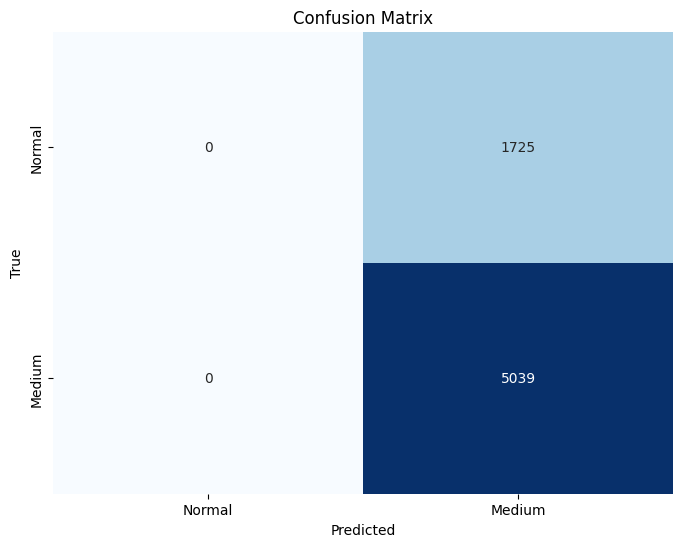

In [20]:
plot_confusion_matrix(cf, save_path='confusion_matrix_'+model_name+'.png',class_names=class_names3)
append_to_csv(model_name+"results.csv", model_name, accuracy,precision,recall,f1)

In [21]:
import zipfile
import os

def zip_directory(directory_path, zip_path):
    # Create a ZipFile object
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Iterate over all the files in the directory
        for root, _, files in os.walk(directory_path):
            for file in files:
                # Add each file to the zip file
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, directory_path))

# Example usage
directory_path = "/kaggle/working/Logs"
zip_path = "/kaggle/working/logs.zip"
zip_directory(directory_path, zip_path)
